In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path


In [2]:
data_path = Path("../Market Data/Crypto Data/cleaned_crypto_data.csv")
df_raw = pd.read_csv(data_path)

def prepare_prices(df: pd.DataFrame) -> pd.DataFrame:
    """
    Expects columns: Date, BTC-USD_close, ETH-USD_close
    Returns daily DataFrame indexed by Date with columns: btc, eth
    """
    out = df.copy()
    out["Date"] = pd.to_datetime(out["Date"])
    out = out.sort_values("Date").set_index("Date")

    out = out.rename(columns={
        "BTC-USD_close": "btc",
        "ETH-USD_close": "eth",
    })

    out = out[["btc", "eth"]].dropna()
    out = out[(out["btc"] > 0) & (out["eth"] > 0)]
    return out

# Example:
# prices = prepare_prices(df_raw)
# prices.head()


In [3]:
def estimate_hedge_ratio(log_btc: pd.Series, log_eth: pd.Series) -> float:
    """
    OLS slope for: log_btc ~ alpha + beta * log_eth
    """
    x = log_eth.values
    y = log_btc.values
    x_mean = x.mean()
    y_mean = y.mean()
    denom = np.sum((x - x_mean) ** 2)
    if denom == 0:
        return 1.0
    beta = np.sum((x - x_mean) * (y - y_mean)) / denom
    return float(beta)

def build_spread(prices: pd.DataFrame, method: str = "regression") -> pd.Series:
    """
    method:
      - "ratio":       x_t = log(btc) - log(eth)       (beta = 1)
      - "regression":  x_t = log(btc) - beta*log(eth)  (beta from OLS)
    """
    log_btc = np.log(prices["btc"])
    log_eth = np.log(prices["eth"])

    if method == "ratio":
        beta = 1.0
    elif method == "regression":
        beta = estimate_hedge_ratio(log_btc, log_eth)
    else:
        raise ValueError("method must be 'ratio' or 'regression'")

    spread = log_btc - beta * log_eth
    spread.name = f"spread_{method}_beta{beta:.4f}"
    spread.attrs["beta"] = beta
    return spread

# Example:
# spread = build_spread(prices, method="regression")
# spread.head(), spread.attrs["beta"]

In [4]:
def ou_mle_fit(x: pd.Series, dt: float = 1.0) -> dict:
    """
    Fit OU params via AR(1) MLE/OLS:
      X_{t+1} = a + b X_t + eps

    Recover:
      b = exp(-theta dt)
      a = mu (1 - b)
      sigma from eps variance
    """
    vals = x.dropna().values
    if len(vals) < 3:
        raise ValueError("Need at least 3 points to fit OU.")

    x_t = vals[:-1]
    x_tp1 = vals[1:]

    X = np.column_stack([np.ones_like(x_t), x_t])
    coef, _, _, _ = np.linalg.lstsq(X, x_tp1, rcond=None)
    a_hat, b_hat = float(coef[0]), float(coef[1])

    # OU wants 0 < b < 1 so theta is positive and real
    b_clipped = min(max(b_hat, 1e-6), 1 - 1e-6)

    resid = x_tp1 - (a_hat + b_hat * x_t)
    s2_eps = float(np.mean(resid ** 2))

    theta = -np.log(b_clipped) / dt
    mu = a_hat / (1 - b_clipped)

    if theta < 1e-8:
        sigma = np.nan
    else:
        sigma = np.sqrt(s2_eps * 2 * theta / (1 - b_clipped**2))

    return {
        "theta": float(theta),
        "mu": float(mu),
        "sigma": float(sigma),
        "a": float(a_hat),
        "b": float(b_hat),
        "b_clipped": float(b_clipped),
        "s2_eps": float(s2_eps),
        "n": int(len(vals)),
    }

def ou_stationary_std(theta: float, sigma: float) -> float:
    """
    Stationary std of OU: sigma_eq = sigma / sqrt(2 theta)
    """
    if theta <= 0 or not np.isfinite(theta) or not np.isfinite(sigma):
        return np.nan
    return float(sigma / np.sqrt(2 * theta))

# Example:
# ou_fit = ou_mle_fit(spread)
# ou_fit

In [5]:
def sharpe_ratio(daily_pnl: pd.Series, annualization: int = 252) -> float:
    x = daily_pnl.dropna()
    if len(x) < 2:
        return np.nan
    sd = x.std(ddof=1)
    if sd == 0:
        return np.nan
    return float((x.mean() / sd) * np.sqrt(annualization))

def backtest_ou_pairs(
    prices: pd.DataFrame,
    spread: pd.Series,
    theta: float,
    mu: float,
    sigma: float,
    entry_z: float = 2.0,
    exit_z: float = 0.5,
    max_leverage: float = 1.0,
) -> tuple[pd.DataFrame, dict]:
    """
    OU z-score:
      z_t = (x_t - mu) / sigma_eq

    Rules:
      - z > entry_z  => short spread
      - z < -entry_z => long spread
      - exit when |z| < exit_z

    Spread:
      x = log(btc) - beta log(eth)

    PnL approximation:
      spread_ret = dlog(btc) - beta*dlog(eth)
      pnl = pos_{t-1} * spread_ret_t
    """
    beta = float(spread.attrs.get("beta", 1.0))
    log_btc = np.log(prices["btc"])
    log_eth = np.log(prices["eth"])

    x = spread.reindex(prices.index).dropna()
    sigma_eq = ou_stationary_std(theta, sigma)

    if np.isfinite(sigma_eq) and sigma_eq > 0:
        z = (x - mu) / sigma_eq
    else:
        z = pd.Series(index=x.index, data=np.nan)
    z.name = "z_ou"

    # pos: +1 long spread, -1 short spread
    pos = pd.Series(index=z.index, data=0.0)
    in_pos = 0.0

    for i in range(len(z)):
        zi = z.iat[i]
        if not np.isfinite(zi):
            pos.iat[i] = in_pos
            continue

        if in_pos == 0.0:
            if zi > entry_z:
                in_pos = -1.0
            elif zi < -entry_z:
                in_pos = 1.0
        else:
            if abs(zi) < exit_z:
                in_pos = 0.0

        pos.iat[i] = in_pos

    pos = pos * float(max_leverage)

    r_btc = log_btc.diff().reindex(pos.index)
    r_eth = log_eth.diff().reindex(pos.index)
    spread_ret = r_btc - beta * r_eth

    pnl = pos.shift(1).fillna(0.0) * spread_ret
    out = pd.DataFrame({
        "spread": x,
        "z": z,
        "pos": pos,
        "spread_ret": spread_ret,
        "pnl": pnl,
    }).dropna()

    out["equity"] = out["pnl"].cumsum()

    metrics = {
        "sharpe": sharpe_ratio(out["pnl"]),
        "mean_daily_pnl": float(out["pnl"].mean()),
        "std_daily_pnl": float(out["pnl"].std(ddof=1)),
        "beta": beta,
        "sigma_eq": float(sigma_eq) if np.isfinite(sigma_eq) else np.nan,
        "entry_z": float(entry_z),
        "exit_z": float(exit_z),
        "n_days": int(len(out)),
    }
    return out, metrics

In [6]:
def random_search_ou(
    prices: pd.DataFrame,
    spread: pd.Series,
    theta0: float,
    mu0: float,
    sigma0: float,
    n_iter: int = 500,
    seed: int = 42,
    # ranges are multipliers around MLE
    theta_mult_range: tuple[float, float] = (0.4, 2.5),
    sigma_mult_range: tuple[float, float] = (0.4, 2.5),
    entry_z_range: tuple[float, float] = (1.0, 3.5),
    exit_z_range: tuple[float, float] = (0.1, 2.0),
):
    rng = np.random.default_rng(seed)

    # guard against bad starting values
    theta0 = float(theta0) if np.isfinite(theta0) and theta0 > 0 else 0.1
    sigma0 = float(sigma0) if np.isfinite(sigma0) and sigma0 > 0 else 0.01

    rows = []
    best = {"sharpe": -np.inf, "bt": None, "metrics": None, "params": None}

    # log-uniform multipliers
    lo_t, hi_t = theta_mult_range
    lo_s, hi_s = sigma_mult_range

    for k in range(n_iter):
        # sample multipliers on log scale
        tm = np.exp(rng.uniform(np.log(lo_t), np.log(hi_t)))
        sm = np.exp(rng.uniform(np.log(lo_s), np.log(hi_s)))

        entry_z = float(rng.uniform(entry_z_range[0], entry_z_range[1]))
        exit_z = float(rng.uniform(exit_z_range[0], exit_z_range[1]))

        # enforce exit < entry
        if exit_z >= entry_z:
            continue

        theta = theta0 * tm
        sigma = sigma0 * sm

        bt, m = backtest_ou_pairs(
            prices=prices,
            spread=spread,
            theta=theta,
            mu=mu0,
            sigma=sigma,
            entry_z=entry_z,
            exit_z=exit_z,
        )
        sh = m["sharpe"]

        rows.append({
            "iter": k,
            "theta": float(theta),
            "sigma": float(sigma),
            "entry_z": float(entry_z),
            "exit_z": float(exit_z),
            "sharpe": float(sh) if np.isfinite(sh) else np.nan,
        })

        if np.isfinite(sh) and sh > best["sharpe"]:
            best = {
                "sharpe": float(sh),
                "bt": bt,
                "metrics": m,
                "params": {
                    "theta": float(theta),
                    "mu": float(mu0),
                    "sigma": float(sigma),
                    "entry_z": float(entry_z),
                    "exit_z": float(exit_z),
                },
            }

    results = pd.DataFrame(rows).sort_values("sharpe", ascending=False)
    return results, best

In [7]:
def backtest_rolling_z(
    prices: pd.DataFrame,
    spread: pd.Series,
    lookback: int = 60,
    entry_z: float = 2.0,
    exit_z: float = 0.5,
    max_leverage: float = 1.0,
):
    beta = float(spread.attrs.get("beta", 1.0))
    log_btc = np.log(prices["btc"])
    log_eth = np.log(prices["eth"])

    x = spread.reindex(prices.index).dropna()
    m = x.rolling(lookback).mean()
    s = x.rolling(lookback).std(ddof=0)
    z = (x - m) / s
    z.name = "z_roll"

    pos = pd.Series(index=z.index, data=0.0)
    in_pos = 0.0

    for i in range(len(z)):
        zi = z.iat[i]
        if not np.isfinite(zi):
            pos.iat[i] = in_pos
            continue

        if in_pos == 0.0:
            if zi > entry_z:
                in_pos = -1.0
            elif zi < -entry_z:
                in_pos = 1.0
        else:
            if abs(zi) < exit_z:
                in_pos = 0.0

        pos.iat[i] = in_pos

    pos = pos * float(max_leverage)

    r_btc = log_btc.diff().reindex(pos.index)
    r_eth = log_eth.diff().reindex(pos.index)
    spread_ret = r_btc - beta * r_eth

    pnl = pos.shift(1).fillna(0.0) * spread_ret
    out = pd.DataFrame({
        "spread": x,
        "z": z,
        "pos": pos,
        "spread_ret": spread_ret,
        "pnl": pnl,
    }).dropna()
    out["equity"] = out["pnl"].cumsum()

    metrics = {
        "sharpe": sharpe_ratio(out["pnl"]),
        "lookback": int(lookback),
        "entry_z": float(entry_z),
        "exit_z": float(exit_z),
        "beta": beta,
        "n_days": int(len(out)),
    }
    return out, metrics

def random_search_rolling(
    prices: pd.DataFrame,
    spread: pd.Series,
    n_iter: int = 300,
    seed: int = 123,
    lookback_range: tuple[int, int] = (20, 200),
    entry_z_range: tuple[float, float] = (1.0, 3.5),
    exit_z_range: tuple[float, float] = (0.1, 2.0),
):
    rng = np.random.default_rng(seed)

    rows = []
    best = {"sharpe": -np.inf, "bt": None, "metrics": None, "params": None}

    for k in range(n_iter):
        lookback = int(rng.integers(lookback_range[0], lookback_range[1] + 1))
        entry_z = float(rng.uniform(entry_z_range[0], entry_z_range[1]))
        exit_z = float(rng.uniform(exit_z_range[0], exit_z_range[1]))

        if exit_z >= entry_z:
            continue

        bt, m = backtest_rolling_z(
            prices=prices,
            spread=spread,
            lookback=lookback,
            entry_z=entry_z,
            exit_z=exit_z,
        )
        sh = m["sharpe"]

        rows.append({
            "iter": k,
            "lookback": lookback,
            "entry_z": float(entry_z),
            "exit_z": float(exit_z),
            "sharpe": float(sh) if np.isfinite(sh) else np.nan,
        })

        if np.isfinite(sh) and sh > best["sharpe"]:
            best = {
                "sharpe": float(sh),
                "bt": bt,
                "metrics": m,
                "params": {
                    "lookback": int(lookback),
                    "entry_z": float(entry_z),
                    "exit_z": float(exit_z),
                },
            }

    results = pd.DataFrame(rows).sort_values("sharpe", ascending=False)
    return results, best

## Strategy vs Buy-and-Hold Visualization

This section runs a simple rolling z-score strategy, compares it to BTC and ETH buy-and-hold, and reports Sharpe and other risk metrics.


Best params: {'lookback': 154, 'entry_z': 3.1954696485457013, 'exit_z': 0.882127684823088}
                    total_return  annualized_return  annualized_vol  sharpe  \
strategy                                                                      
Rolling Z Strategy        1.4548             0.0559          0.3285  0.3259   
BTC Buy & Hold           10.2241             0.1578          0.5610  0.5494   
ETH Buy & Hold            3.2690             0.0919          4.0574  0.2720   

                    max_drawdown_log  
strategy                              
Rolling Z Strategy           -0.9113  
BTC Buy & Hold               -2.1588  
ETH Buy & Hold               -3.7660  


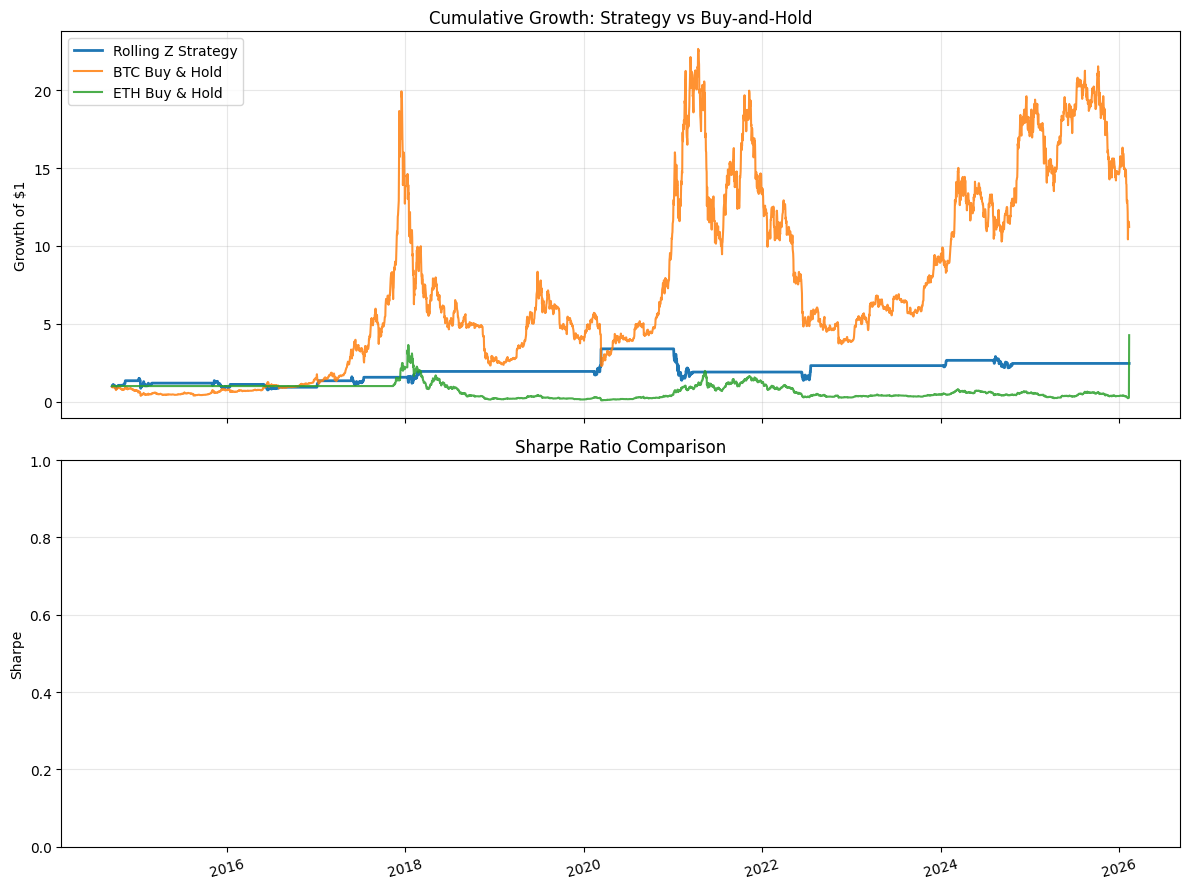

In [8]:
def max_drawdown(equity_curve: pd.Series) -> float:
    running_max = equity_curve.cummax()
    drawdown = equity_curve - running_max
    return float(drawdown.min())


def summarize_performance(daily_returns: pd.Series, name: str) -> dict:
    daily_returns = daily_returns.dropna()
    equity = (1 + daily_returns).cumprod()
    total_return = float(equity.iloc[-1] - 1.0) if len(equity) else np.nan
    ann_return = float((1 + total_return) ** (252 / len(daily_returns)) - 1) if len(daily_returns) else np.nan
    ann_vol = float(daily_returns.std(ddof=1) * np.sqrt(252)) if len(daily_returns) > 1 else np.nan
    sharpe = sharpe_ratio(daily_returns)
    mdd = max_drawdown(np.log(equity)) if len(equity) else np.nan
    return {
        "strategy": name,
        "total_return": total_return,
        "annualized_return": ann_return,
        "annualized_vol": ann_vol,
        "sharpe": sharpe,
        "max_drawdown_log": mdd,
    }


prices = prepare_prices(df_raw)
spread = build_spread(prices, method="regression")

search_results, best = random_search_rolling(prices, spread, n_iter=250, seed=7)
if best["bt"] is None:
    raise RuntimeError("Random search did not find a valid parameter set.")

bt = best["bt"].copy()
strategy_daily = bt["pnl"]
strategy_equity = (1 + strategy_daily).cumprod()

btc_daily = np.log(prices["btc"]).diff().reindex(bt.index).fillna(0.0)
eth_daily = np.log(prices["eth"]).diff().reindex(bt.index).fillna(0.0)
btc_equity = (1 + btc_daily).cumprod()
eth_equity = (1 + eth_daily).cumprod()

metrics_df = pd.DataFrame([
    summarize_performance(strategy_daily, "Rolling Z Strategy"),
    summarize_performance(btc_daily, "BTC Buy & Hold"),
    summarize_performance(eth_daily, "ETH Buy & Hold"),
]).set_index("strategy")

print("Best params:", best["params"])
print(metrics_df.round(4))

fig, axes = plt.subplots(2, 1, figsize=(12, 9), sharex=True)

axes[0].plot(strategy_equity.index, strategy_equity, label="Rolling Z Strategy", linewidth=2)
axes[0].plot(btc_equity.index, btc_equity, label="BTC Buy & Hold", alpha=0.85)
axes[0].plot(eth_equity.index, eth_equity, label="ETH Buy & Hold", alpha=0.85)
axes[0].set_title("Cumulative Growth: Strategy vs Buy-and-Hold")
axes[0].set_ylabel("Growth of $1")
axes[0].grid(True, alpha=0.3)
axes[0].legend(loc="best")

sharpe_values = metrics_df["sharpe"].sort_values(ascending=False)
axes[1].set_title("Sharpe Ratio Comparison")
axes[1].set_ylabel("Sharpe")
axes[1].grid(True, axis="y", alpha=0.3)

plt.xticks(rotation=15)
plt.tight_layout()
plt.show()
